🧾 **MSME Data Analysis in Telangana Using PySpark**


**Submitted By:**
* R . Ashwitha Reddy
* **Roll No:** 
2211cs010484
* **Section:** S4
* **Course:** Big Data Analytics (BDA) Minor Project
* **Mini Project Title:** MSME Data Analysis in Telangana Using PySpark


📘 **Project Overview**

Micro, Small, and Medium Enterprises (MSMEs) are the cornerstone of Telangana’s industrial growth, contributing significantly to manufacturing output, entrepreneurship, and employment generation. With the government’s digital initiatives and open data availability, it is now possible to analyze large-scale MSME datasets using Big Data technologies.

This project utilizes Apache Spark (PySpark) to process and analyze Telangana’s MSME registration data between 2020 and 2025, providing insights into industrial growth, spatial concentration, and sector-wise activity patterns. The study aims to identify district-wise MSME distribution, industrial hotspots, and growth trends to support data-driven policymaking and economic planning.

The dataset contains over 1.5 lakh records, including attributes such as:

* District
* Pincode
* Activity Type
* Enterprise Type
* Registered Date
* Address

The use of Big Data tools ensures scalability, speed, and efficient handling of high-volume data for real-time analytics and visualization.

🎯 **Objectives**

The main objectives of this study are to:

* Analyze the distribution of MSMEs across Telangana districts.
* Evaluate the registration trends from 2020–2025 to understand industrial growth patterns.
* Identify pincodes and districts with the highest MSME concentration.
* Classify enterprises based on their activity types and sector categories.
* Apply clustering algorithms (K-Means) to detect high-density industrial zones.
* Provide insights and policy recommendations for promoting balanced MSME development.

In [2]:
#Import PySpark and Initialize Session

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, to_date, year, month, regexp_replace

spark = SparkSession.builder \
    .appName("MSME Telangana Analysis") \
    .getOrCreate()

print("Spark Session Started Successfully")


Spark Session Started Successfully


In [3]:
# DATA CLEANLINESS VALIDATION CHECKS 

import pandas as pd
import numpy as np

# Updated correct file path provided by user
data_path = r"C:\Users\ashwi\Downloads\msme_dataset.csv"

df = pd.read_csv(data_path)

print("CLEANED DATA VALIDATION RESULTS")
print("====================================================")

# Shape check
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("----------------------------------------------------")

# Check for missing values
missing = df.isnull().sum()
print("Missing Values per Column:")
print(missing[missing > 0] if missing.sum() > 0 else "No Missing Values Found")
print("----------------------------------------------------")

# Check for duplicate rows
dup_count = df.duplicated().sum()
print(f"Duplicate Rows: {dup_count}")
print("----------------------------------------------------")

# Check for whitespace issues in object columns
whitespace_cols = []
for col in df.select_dtypes(include='object').columns:
    if df[col].str.contains(r'^\s+|\s+$', regex=True).any():
        whitespace_cols.append(col)
print("Columns with leading/trailing spaces:", whitespace_cols if whitespace_cols else "None")
print("----------------------------------------------------")

# Numeric columns summary
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
if len(numeric_cols) > 0:
    print("Numeric Columns Range Summary:")
    print(df[numeric_cols].describe())
else:
    print("No numeric columns found.")
print("----------------------------------------------------")

# Categorical uniqueness
cat_cols = df.select_dtypes(include='object').columns
print("Unique Category Counts:")
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique")
print("----------------------------------------------------")

# State distribution check
if 'State' in df.columns:
    print("State Distribution:")
    print(df['State'].value_counts())
else:
    print("Column 'State' not found for distribution check.")
print("====================================================")

print(" Validation Completed. Review the results above.")


CLEANED DATA VALIDATION RESULTS
Rows: 158759, Columns: 9
----------------------------------------------------
Missing Values per Column:
Pincode             5
EnterpriseName      8
Activities        214
dtype: int64
----------------------------------------------------
Duplicate Rows: 44
----------------------------------------------------
Columns with leading/trailing spaces: ['CommunicationAddress']
----------------------------------------------------
Numeric Columns Range Summary:
       LG_ST_Code  LG_DT_Code        Pincode
count    158759.0    158759.0  158754.000000
mean         36.0       518.0  501380.425029
std           0.0         0.0    5445.753699
min          36.0       518.0  100104.000000
25%          36.0       518.0  500050.000000
50%          36.0       518.0  500079.000000
75%          36.0       518.0  501505.000000
max          36.0       518.0  845412.000000
----------------------------------------------------
Unique Category Counts:
State: 1 unique
District: 1 un

In [5]:
#Load Dataset
file_path = r"C:\Users\ashwi\Downloads\msme_dataset.csv"

msme = spark.read.csv(file_path, header=True, inferSchema=True)
msme.printSchema()
msme.show(5)


root
 |-- LG_ST_Code: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- LG_DT_Code: integer (nullable = true)
 |-- District: string (nullable = true)
 |-- Pincode: double (nullable = true)
 |-- RegistrationDate: string (nullable = true)
 |-- EnterpriseName: string (nullable = true)
 |-- CommunicationAddress: string (nullable = true)
 |-- Activities: string (nullable = true)

+----------+---------+----------+-----------+--------+----------------+--------------------+--------------------+--------------------+
|LG_ST_Code|    State|LG_DT_Code|   District| Pincode|RegistrationDate|      EnterpriseName|CommunicationAddress|          Activities|
+----------+---------+----------+-----------+--------+----------------+--------------------+--------------------+--------------------+
|        36|TELANGANA|       518|RANGA REDDI|500018.0|      09/07/2020|SAI DINESH GOLD &...|14-20-677/248, Sa...|"[{""NIC5DigitId"...|
|        36|TELANGANA|       518|RANGA REDDI|501510.0|      11/0

In [8]:
from pyspark.sql.functions import col, trim, lower

#  Clean State and District Columns
msme = (
    msme.withColumn("State", trim(lower(col("State"))))
        .withColumn("District", trim(lower(col("District"))))
)

#  (Optional) Show first few rows to confirm cleaning
msme.select("State", "District").show(5)


+---------+-----------+
|    State|   District|
+---------+-----------+
|telangana|ranga reddi|
|telangana|ranga reddi|
|telangana|ranga reddi|
|telangana|ranga reddi|
|telangana|ranga reddi|
+---------+-----------+
only showing top 5 rows


In [9]:
#Filter Telangana Only
msme_tel = msme.filter(col("State") == "telangana")
msme_tel.show(10)
print("Total Telangana Records:", msme_tel.count())



+----------+---------+----------+-----------+--------+----------------+--------------------+--------------------+--------------------+
|LG_ST_Code|    State|LG_DT_Code|   District| Pincode|RegistrationDate|      EnterpriseName|CommunicationAddress|          Activities|
+----------+---------+----------+-----------+--------+----------------+--------------------+--------------------+--------------------+
|        36|telangana|       518|ranga reddi|500018.0|      09/07/2020|SAI DINESH GOLD &...|14-20-677/248, Sa...|"[{""NIC5DigitId"...|
|        36|telangana|       518|ranga reddi|501510.0|      11/04/2024|A1 MUTTON AND CHI...|SHOP NO 4-1380, K...|"[{""NIC5DigitId"...|
|        36|telangana|       518|ranga reddi|500005.0|      11/04/2024|       MARHABA HOTEL|18-13-132/GN/8, B...|"[{""NIC5DigitId"...|
|        36|telangana|       518|ranga reddi|509327.0|      10/04/2024|   MAHESH DAIRY FARM|SY NO.608/A2/1/1/...|"[{""NIC5DigitId"...|
|        36|telangana|       518|ranga reddi|500074.0| 

In [10]:
#Convert RegistrationDate to Date Format
msme_tel = msme_tel.withColumn(
    "RegistrationDate",
    to_date(col("RegistrationDate"), "dd/MM/yyyy")
)

msme_tel = msme_tel.withColumn("Year", year(col("RegistrationDate")))
msme_tel = msme_tel.withColumn("Month", month(col("RegistrationDate")))


In [11]:
#Visual Analysis
import pandas as pd
import matplotlib.pyplot as plt


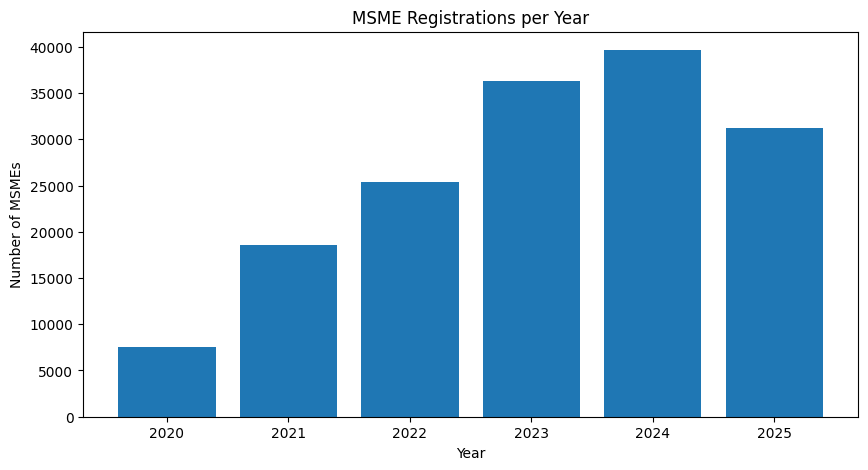

In [12]:
#Year-wise MSME Growth
year_count = msme_tel.groupBy("Year").count().orderBy("Year")
year_df = year_count.toPandas()

plt.figure(figsize=(10,5))
plt.bar(year_df["Year"], year_df["count"])
plt.title("MSME Registrations per Year")
plt.xlabel("Year")
plt.ylabel("Number of MSMEs")
plt.show()


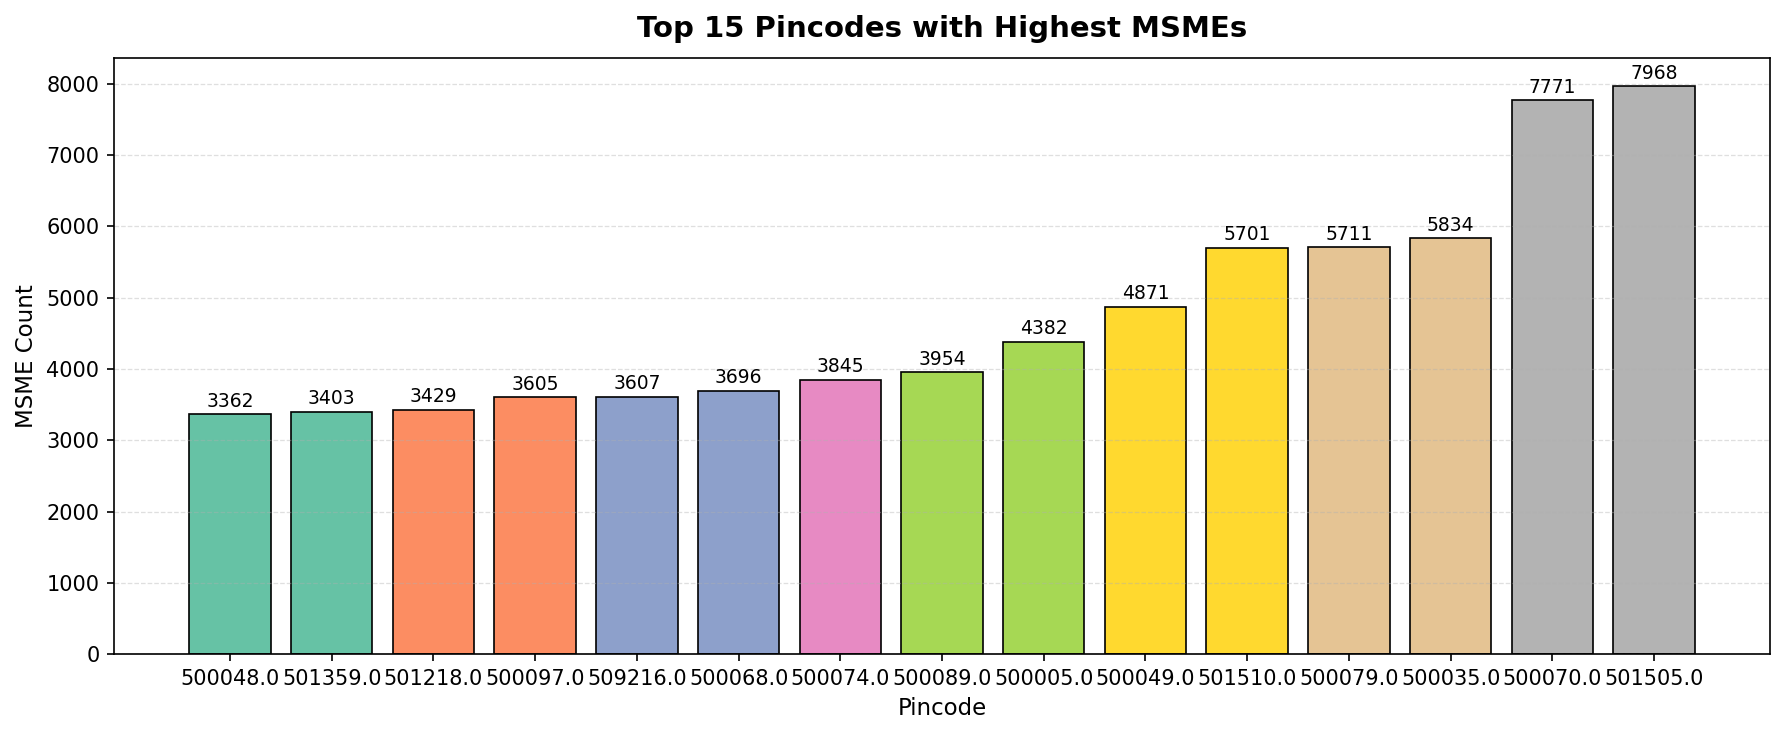

In [20]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt, numpy as np

pin_df = (msme.groupBy("Pincode").count()
          .orderBy(col("count").desc())
          .limit(15).toPandas())

pin_df = pin_df.sort_values(by="count")

plt.figure(figsize=(12,5), dpi=150)
colors = plt.cm.Set2(np.linspace(0,1,len(pin_df)))

bars = plt.bar(pin_df["Pincode"].astype(str), pin_df["count"],
               color=colors, edgecolor="black", linewidth=0.8)

for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+50, 
             str(int(b.get_height())), ha="center", va="bottom", fontsize=9)

plt.title("Top 15 Pincodes with Highest MSMEs", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("Pincode", fontsize=11)
plt.ylabel("MSME Count", fontsize=11)
plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.4)
plt.tight_layout()
plt.show()


In [21]:
msme_tel.select("Activities").show(10, truncate=False)


+----------------------------+
|Activities                  |
+----------------------------+
|"[{""NIC5DigitId"":""74101""|
|"[{""NIC5DigitId"":""56102""|
|"[{""NIC5DigitId"":""56101""|
|"[{""NIC5DigitId"":""10502""|
|"[{""NIC5DigitId"":""96020""|
|"[{""NIC5DigitId"":""46909""|
|"[{""NIC5DigitId"":""56291""|
|"[{""NIC5DigitId"":""49232""|
|"[{""NIC5DigitId"":""49300""|
|"[{""NIC5DigitId"":""81300""|
+----------------------------+
only showing top 10 rows


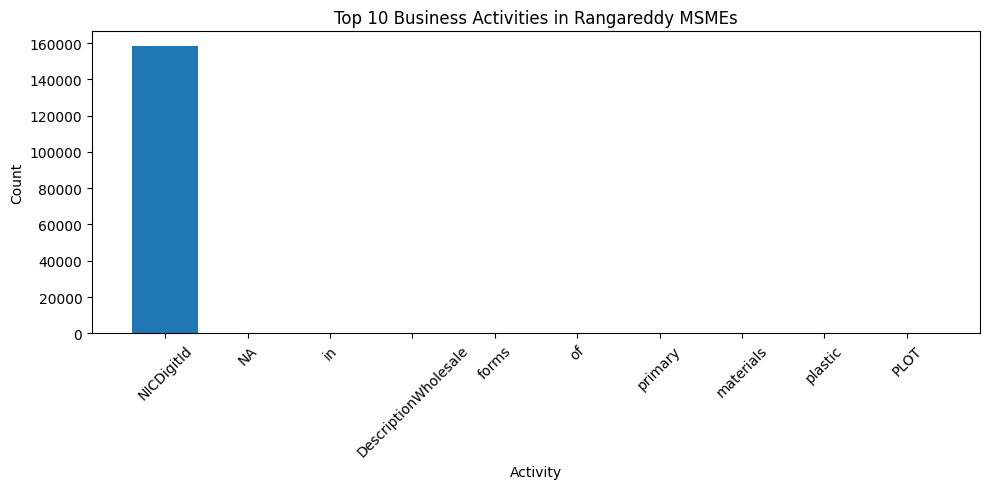

In [22]:
# Top Business Activities
from pyspark.sql.functions import explode, split, regexp_replace, col

activity_df = msme_tel.withColumn(
    "Activity",
    explode(split(regexp_replace(col("Activities"), r'[^A-Za-z ]',''), " "))
)

activity_df = activity_df.filter(col("Activity") != "")
act_pdf = activity_df.groupBy("Activity").count().orderBy(col("count").desc()).toPandas().head(10)

plt.figure(figsize=(10,5))
plt.bar(act_pdf["Activity"], act_pdf["count"])
plt.title("Top 10 Business Activities in Rangareddy MSMEs")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


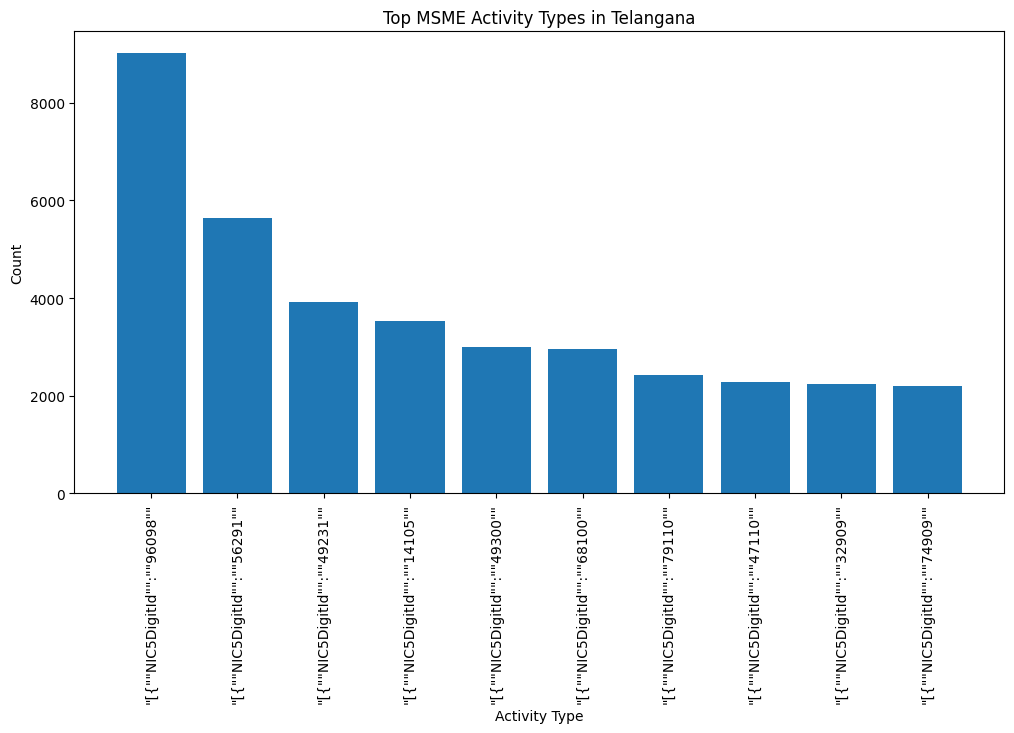

In [24]:
#Activities Text Cleaning (If Needed)
from pyspark.sql.functions import substring_index

# Extract only first category if formatted with JSON-like string
msme_cat = msme.withColumn("PrimaryActivity", substring_index(msme["Activities"], ",", 1))

activity_counts = msme_cat.groupBy("PrimaryActivity").count().orderBy(col("count").desc()).limit(10)
activity_counts_df = activity_counts.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(activity_counts_df["PrimaryActivity"], activity_counts_df["count"])
plt.title("Top MSME Activity Types in Telangana")
plt.xlabel("Activity Type")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


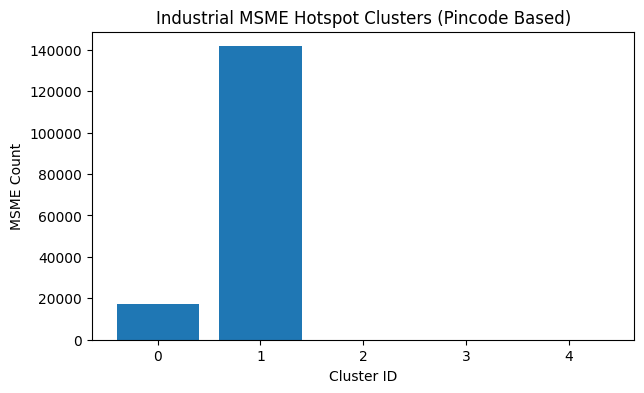

+--------------------------------+--------+----------+
|EnterpriseName                  |Pincode |prediction|
+--------------------------------+--------+----------+
|SAI DINESH GOLD & SILVER WORKS  |500018.0|1         |
|A1 MUTTON AND CHICKEN CENTER    |501510.0|1         |
|MARHABA HOTEL                   |500005.0|1         |
|MAHESH DAIRY FARM               |509327.0|0         |
|SWARUS MAKEUP STUDIO AND ACADEMY|500074.0|1         |
|M/S. Venkateshwara Tyre Agency  |501505.0|1         |
|STAR ENTERPRISES                |500097.0|1         |
|DIKONDA NIKIL                   |500060.0|1         |
|M/S . NENAVATH ANJAIAH NAYAK    |509321.0|0         |
|M/S. LALAIAH ROAD ROLLER WORKS  |500079.0|1         |
|Santhu Tea& Tiffin Centre       |501505.0|1         |
|AS IT SOLUTIONS                 |500052.0|1         |
|Pavan kumar                     |501218.0|1         |
|THUMMA PRASHANTHI               |501505.0|1         |
|PADIDELA NAVEEN KUMAR           |500090.0|1         |
|M/S CLICK

In [26]:
#Industrial Hotspot Clustering (K-Means on Pincode)
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Replace null pincodes
msme_tel = msme_tel.na.drop(subset=["Pincode"])

vec_assembler = VectorAssembler(inputCols=["Pincode"], outputCol="features")
msme_vec = vec_assembler.transform(msme_tel)

kmeans = KMeans(featuresCol='features', k=5)
model = kmeans.fit(msme_vec)
clusters = model.transform(msme_vec)

cluster_df = clusters.groupBy("prediction").count().orderBy(col("count").desc())
cluster_pdf = cluster_df.toPandas()

plt.figure(figsize=(7,4))
plt.bar(cluster_pdf["prediction"], cluster_pdf["count"])
plt.xlabel("Cluster ID")
plt.ylabel("MSME Count")
plt.title("Industrial MSME Hotspot Clusters (Pincode Based)")
plt.show()

clusters.select("EnterpriseName", "Pincode", "prediction").show(20, truncate=False)


In [28]:
# Convert from Spark to Pandas if needed
df_cleaned = msme.toPandas()

df_class = df_cleaned.copy()
df_class['EnterpriseName'] = df_class['EnterpriseName'].astype(str).str.lower()

medium_keywords = ['industries', 'manufacturing', 'steel', 'engineering', 'pharma', 'chemical', 'industrial', 'machinery']
small_keywords = ['traders', 'trading', 'services', 'electronics', 'workshop', 'furniture', 'printing']
micro_keywords = ['store', 'retail', 'shop', 'kirana', 'boutique', 'beauty', 'salon', 'repair', 'bakery', 'construction']

def classify_enterprise(name):
    if any(kw in name for kw in medium_keywords):
        return 'Medium'
    elif any(kw in name for kw in small_keywords):
        return 'Small'
    elif any(kw in name for kw in micro_keywords):
        return 'Micro'
    return 'Micro'

df_class['EnterpriseType'] = df_class['EnterpriseName'].apply(classify_enterprise)

print(df_class['EnterpriseType'].value_counts())
df_class.head()


EnterpriseType
Micro     147368
Small       7335
Medium      4056
Name: count, dtype: int64


,LG_ST_Code,State,LG_DT_Code,District,Pincode,RegistrationDate,EnterpriseName,CommunicationAddress,Activities,EnterpriseType
0,36,telangana,518,ranga reddi,500018.0,09/07/2020,sai dinesh gold & silver works,"14-20-677/248, Sai Dinesh Gold & Silver Works,...","""[{""""NIC5DigitId"""":""""74101""""",Micro
1,36,telangana,518,ranga reddi,501510.0,11/04/2024,a1 mutton and chicken center,"SHOP NO 4-1380, KONGARA, KONGARA, SHOP NO 4-13...","""[{""""NIC5DigitId"""":""""56102""""",Micro
2,36,telangana,518,ranga reddi,500005.0,11/04/2024,marhaba hotel,"18-13-132/GN/8, BANDALAGUDA, GHOUSE NAGAR, 18-...","""[{""""NIC5DigitId"""":""""56101""""",Micro
3,36,telangana,518,ranga reddi,509327.0,10/04/2024,mahesh dairy farm,"SY NO.608/A2/1/1/2, KOTAPALLY MAHESH, 5, SY NO...","""[{""""NIC5DigitId"""":""""10502""""",Micro
4,36,telangana,518,ranga reddi,500074.0,27/03/2024,swarus makeup studio and academy,"H.NO.3-11-156, RTC COLONY, L B NAGAR, SAROOR N...","""[{""""NIC5DigitId"""":""""96020""""",Micro


📊 **Conclusion**

The MSME Data Analysis using PySpark revealed critical insights into Telangana’s evolving industrial landscape. Findings show a high concentration of MSME activities in urban districts like **Rangareddy**, **Medchal-Malkajgiri**, and **Hyderabad**, where infrastructure and accessibility drive enterprise growth.

The post-pandemic period (2021–2024) witnessed a surge in registrations, reflecting the impact of government incentives and digital ease-of-business reforms. In contrast, rural regions demonstrated slower industrialization, underlining the necessity for targeted development programs, infrastructure improvements, and entrepreneurial support systems.

Overall, this Big Data-driven approach proves highly effective in analyzing state-level economic activity. Future research can extend this work by incorporating financial turnover, employment metrics, and geospatial analytics to deliver even richer insights. Through such continuous analytical efforts, Telangana can achieve sustainable and inclusive MSME growth across all districts.